# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

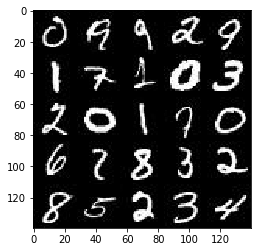

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

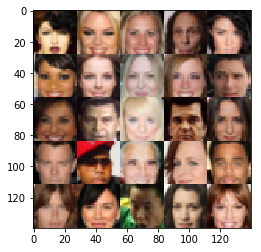

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        l1 = tf.layers.conv2d(images, 64, kernel_size = 5, strides = 2, padding = 'same')
        lrelu1 = lrelu(l1, alpha)
        #16x16x64
        
        l2 = tf.layers.conv2d(lrelu1, 128, kernel_size = 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(l2, training = True)
        lrelu2 = lrelu(l2, alpha)
        #8x8x128
        
        l3 = tf.layers.conv2d(lrelu2, 256, kernel_size = 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(l3, training = True)
        lrelu3 = lrelu(l3, alpha)
        #4x4x256
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = (not is_train)):
    
        l1 = tf.layers.dense(z, 7 * 7 * 256)

        l1 = tf.reshape(l1, (-1, 7, 7, 256))
        b1 = tf.layers.batch_normalization(l1, training = is_train)
        lrelu1 = lrelu(b1, alpha)
        #7x7x256

        l2 = tf.layers.conv2d_transpose(lrelu1, 128, kernel_size = 5, strides = 2, padding = 'same')
        b2 = tf.layers.batch_normalization(l2, training = is_train)
        lrelu2 = lrelu(b2, alpha)
        #14x14x128

        l3 = tf.layers.conv2d_transpose(lrelu2, 64, kernel_size = 5, strides = 2, padding = 'same')
        b3 = tf.layers.batch_normalization(l3, training = is_train)
        lrelu3 = lrelu(b3, alpha)
        #28x28x64

        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, kernel_size = 3, strides = 1, padding = 'same')

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim, is_train = True, alpha = alpha)
    
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, alpha = alpha)
    
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse = True, alpha = alpha)
    
    discriminator_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    
    discriminator_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    treinable_variables = tf.trainable_variables()
    discriminator_variables = [variable for variable in treinable_variables if variable.name.startswith('discriminator')]
    generator_variables = [variable for variable in treinable_variables if variable.name.startswith('generator')]
    
    discriminator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = discriminator_variables)
    generator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = generator_variables)
    
    return discriminator_training_optimizer, generator_training_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.4231
Epoch 1/2... Discriminator Loss: 0.1537... Generator Loss: 2.7166
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 0.5080... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.0274
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.0230
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.7344


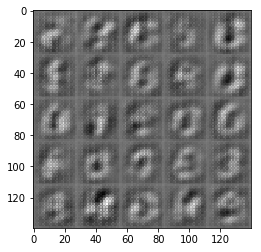

Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.7519


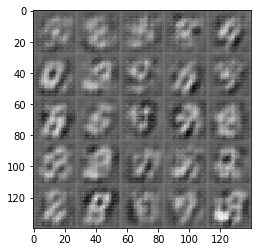

Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7265


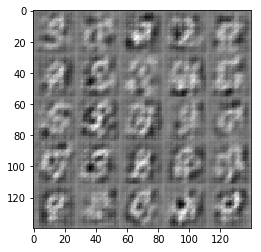

Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.6942


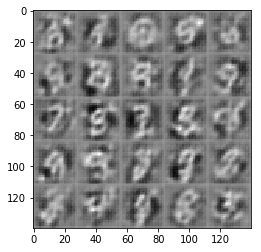

Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.2209
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.7581


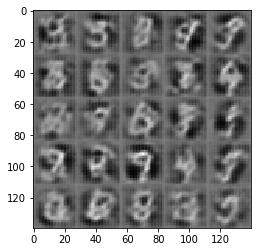

Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.3453
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.7488


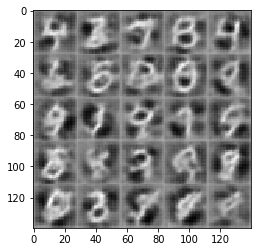

Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.9165


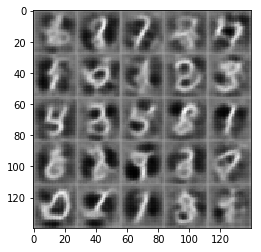

Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.7520
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.8596


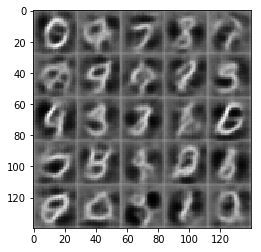

Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.7822


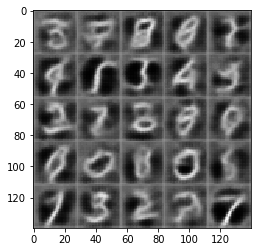

Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8899


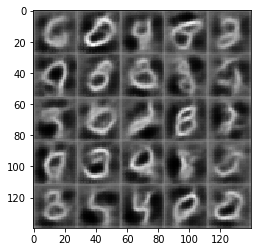

Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.7427
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 1.1938
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.8835


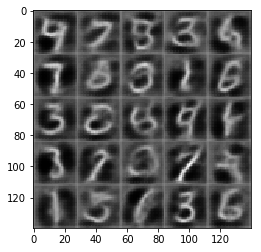

Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.8113


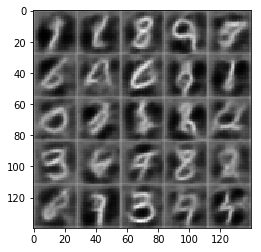

Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.0041
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.8610


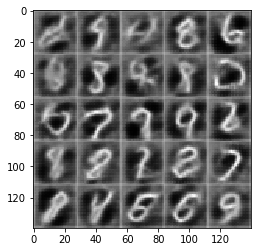

Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.6939
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.9918


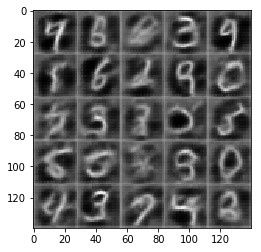

Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.7532


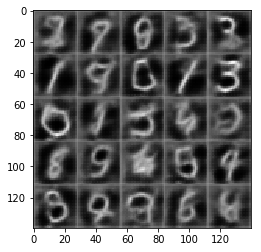

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 1.1804
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.8573
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.6190
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.8652


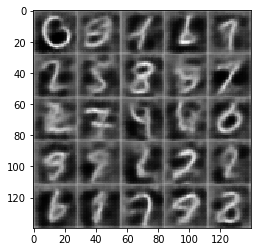

Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.6725


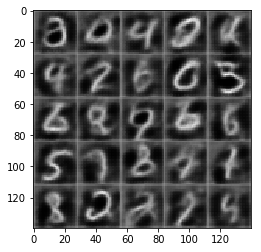

Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.7609


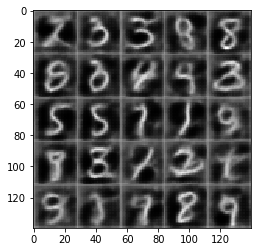

Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.9490
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.5693
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.9815


In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 4.1697
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 4.5641
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 3.8943
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 2.1536
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 2.9926
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 4.5438
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 2.7499
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.2409


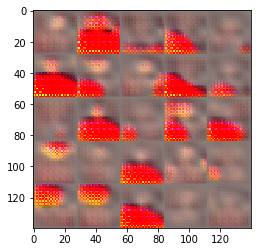

Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.5690
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.7288
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 2.4792
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.1177


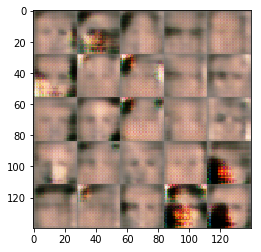

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9356


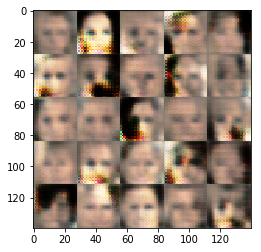

Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.9416
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8588


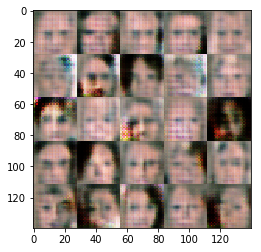

Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8847


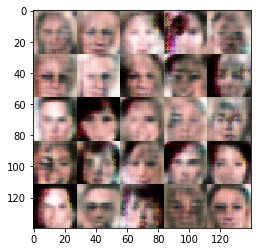

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.9746


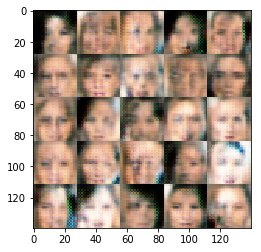

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8078


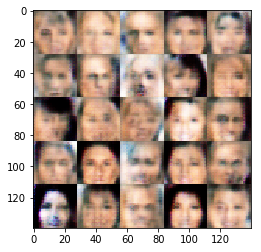

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6742


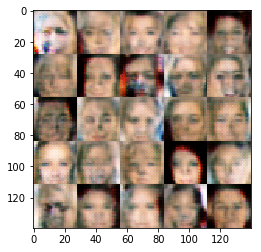

Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.5800
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8261


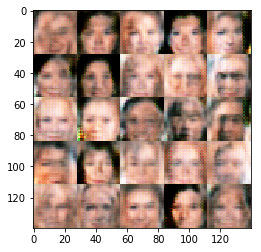

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.6711


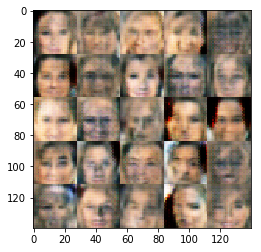

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6197


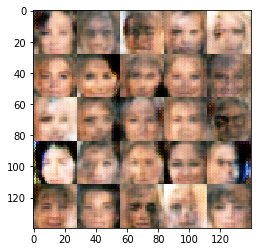

Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9305


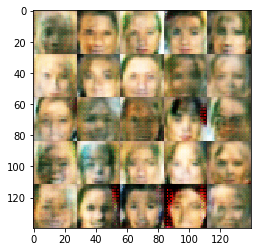

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6192


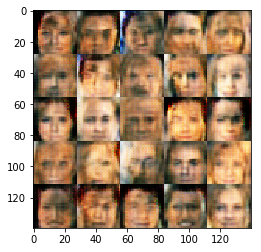

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8154


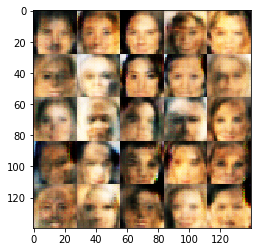

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.0609


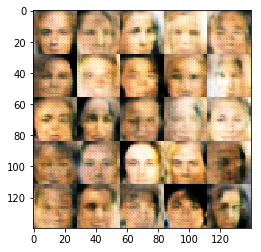

Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6274


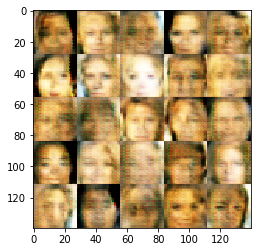

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9760


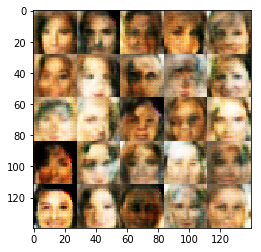

Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7885


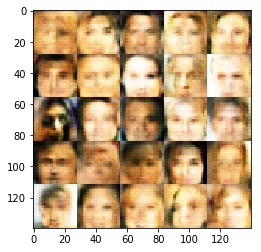

Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.3743
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7920


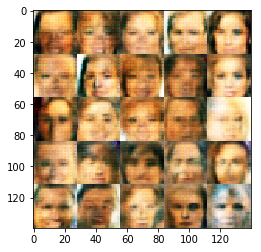

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9401


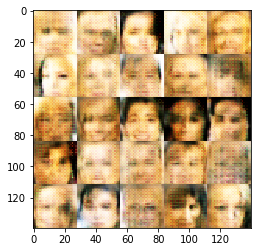

Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7426


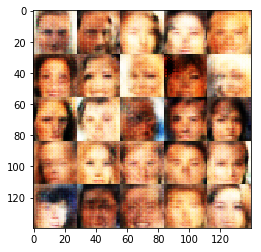

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6974


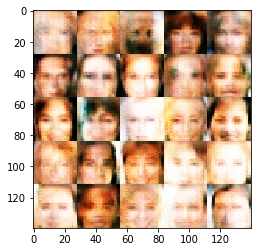

Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1809


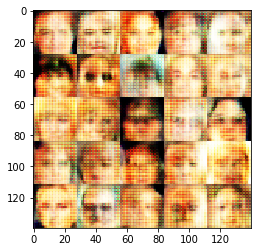

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7926


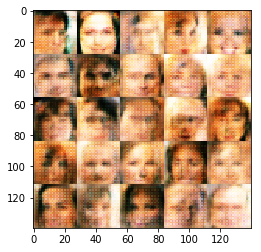

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.8373


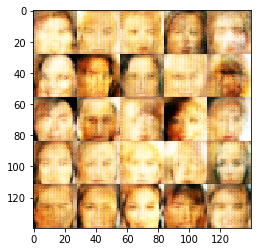

Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8055


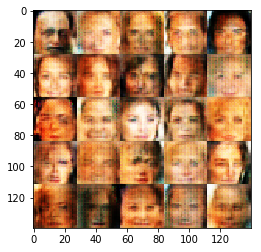

Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7466


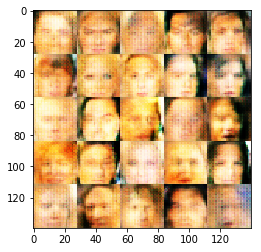

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.1394


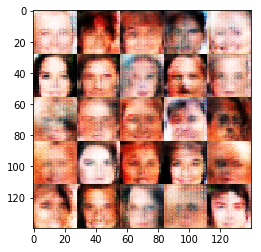

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6392


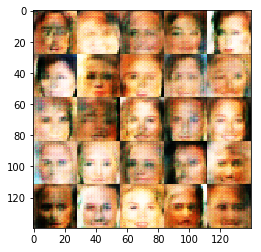

Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6739


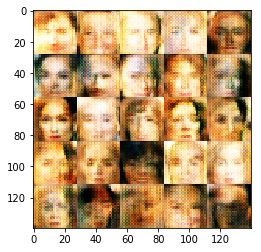

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8138


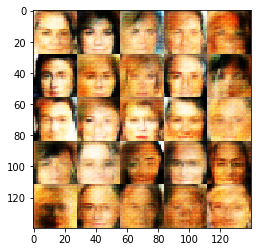

Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.9184


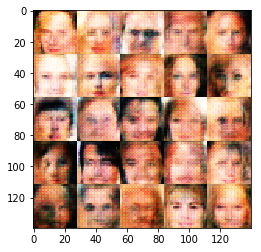

Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.3089
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.9276


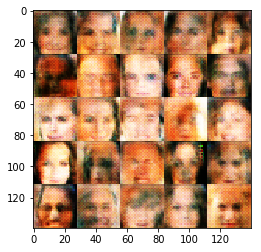

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9165


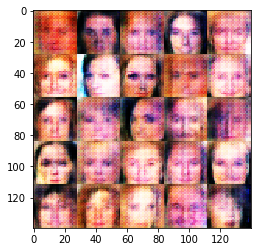

Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.8386


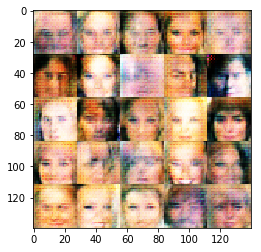

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.2121
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8735


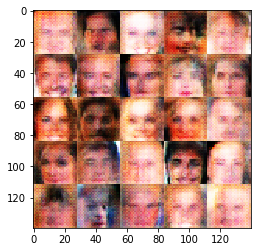

Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5313


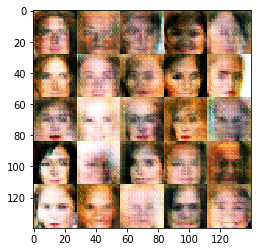

Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9729


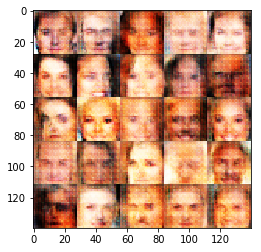

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 2.4664
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.6995


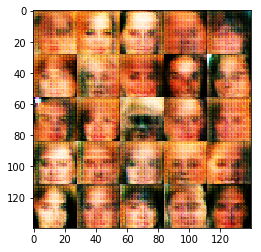

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8633


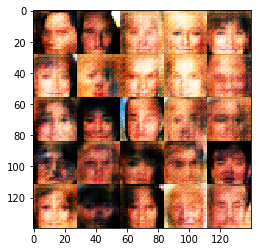

Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.9643


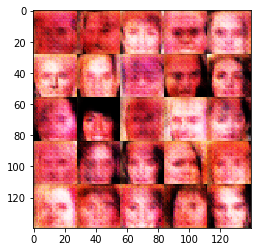

Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1069


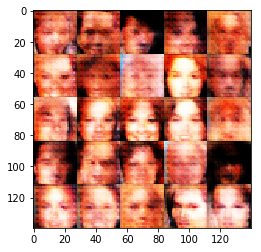

Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 1.9294
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8386


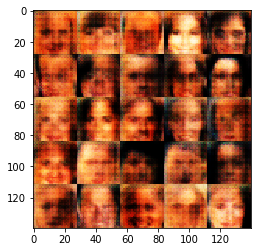

Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7144


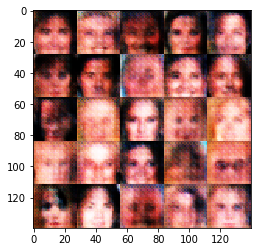

Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7925


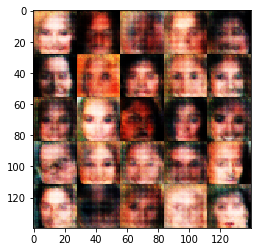

Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 1.9439... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.5601


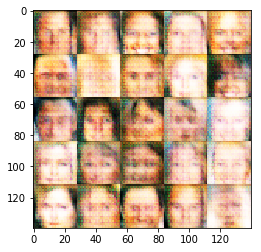

Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.1743


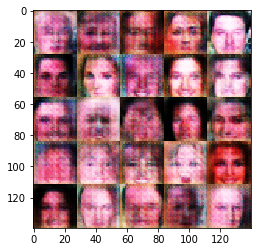

Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4428


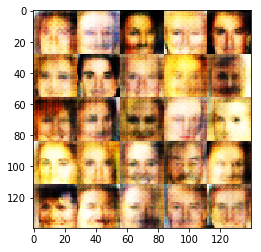

Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7093


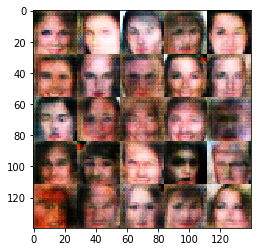

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8342


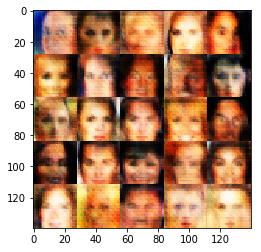

Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8479


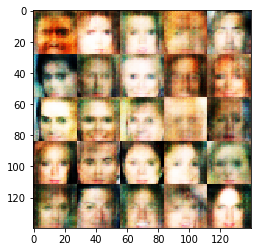

Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9647


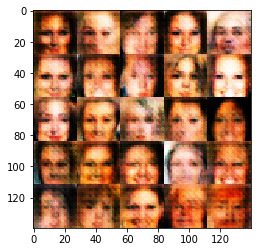

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7420


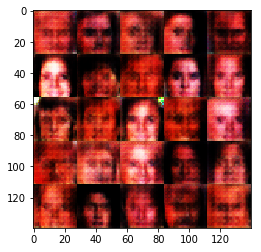

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8183


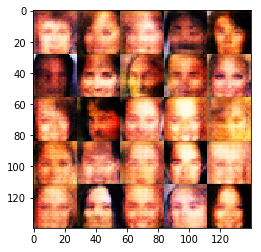

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8371


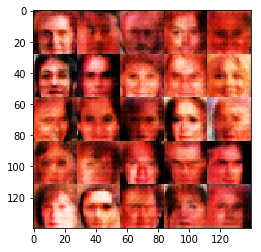

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5448


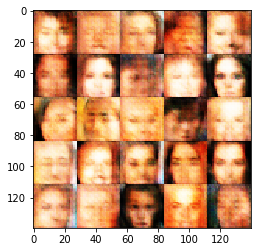

Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9857


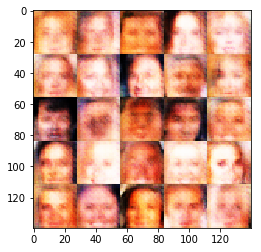

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7211


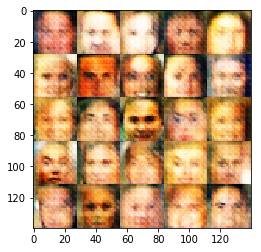

Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5195


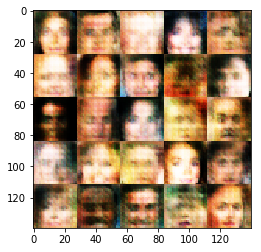

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8455


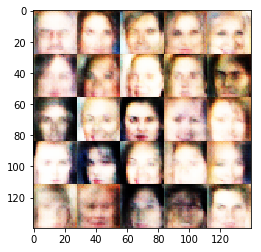

Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7782


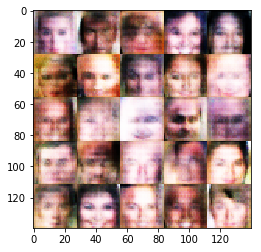

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.6927


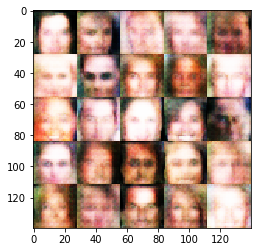

Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6350


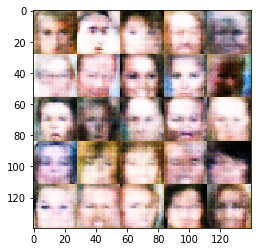

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.6560


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0009
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.